In [55]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import glob, os
import numpy as np
import csv
import pandas as pd
import seaborn as sns
import librosa
from scipy.io import wavfile
sns.set_style("whitegrid")
from IPython.display import Markdown, display, Audio
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Stimulus Generation

Generate stimuli for looming experiment (Benghanem et al., 2022)\
&copy; JJ Aucouturier, 2021

## Looming sound

Pure tone, duration 500ms, 10dB rise 

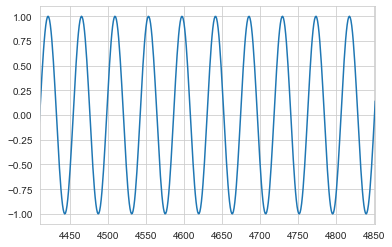

In [157]:
def generate_pure_tone(amplitude, f_zero, duration, sample_rate):
    
    t = np.arange(sample_rate*duration/1000)
    y = (amplitude*np.sin(2*np.pi*f_zero/sample_rate*t)).astype(np.float32)
    return t,y

t,y = generate_pure_tone(amplitude = 1.0,
                         f_zero = 1000,
                         duration = 500,
                         sample_rate = 44100)
    
Audio(data=y, rate=sample_rate)
_=plt.plot(t,y)
_=plt.xlim([0.1*sample_rate,0.11*sample_rate])

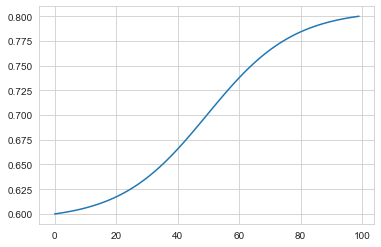

In [158]:
def sigmoid(x_min=0, x_max=100, y_min=-1, y_max=1, n_points=100, slope = 7): 
    
    # sample n_points between x_min and x_max
    x = np.linspace(start=x_min,
                    stop=x_max,
                    num=n_points)
    
    # center sigmoid at midrange
    center= np.median(x)
    
    # scale slope to range 
    slope = slope / (x_max-x_min)
    y = 1 / (1 + np.exp(-slope*(x-center)))
    
    # scale between y_min et y_max
    y = (y_max-y_min)*(y - np.min(y))/(np.max(y)-np.min(y)) + y_min
    
    return y

sig = sigmoid(x_min=0,x_max=1,
            y_min = 0.6,y_max=0.8,
            n_points=100,
            slope=7)
plt.plot(sig)

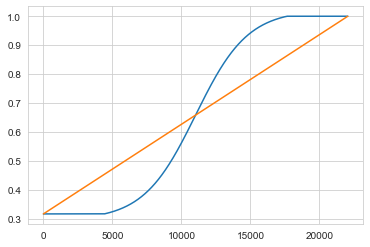

In [160]:
def generate_ramp (decibel = 10,
                   n_points = 100,
                   n_start = 20, 
                   n_end = 20,
                   is_sigmoid = True,
                   slope = 7): 
                       
    # ramp from -decibel dB to 0dB, ie from amplitude: 10^(-decibel/20) to 1.0     
    end_amplitude = 1.0
    start_amplitude =  np.power(10,-decibel/20)
    
    # start flat for n_start points
    ramp = [start_amplitude]*n_start
    
    n_points = n_points - n_start - n_end
    
    if is_sigmoid: 
        ramp += list(sigmoid(x_min = 0,
                       x_max = n_points,
                       y_min = start_amplitude,
                       y_max = end_amplitude,
                       n_points = n_points,
                       slope = slope))
    else:
        # linear ramp
        ramp += list(np.arange(0,n_points)/n_points*(end_amplitude-start_amplitude) + start_amplitude)
        
    ramp += [end_amplitude]*n_start

    return ramp
    
sigmoid_ramp = generate_ramp(decibel = 10,
                              n_points = len(y),
                              n_start = int(0.1*sample_rate),
                              n_end = int(0.1*sample_rate),
                              is_sigmoid = True)
linear_ramp = generate_ramp (decibel = 10,
                              n_points = len(y),
                             n_start = 0,
                             n_end = 0,
                              is_sigmoid = False)

_=plt.plot(sigmoid_ramp)
_=plt.plot(linear_ramp)



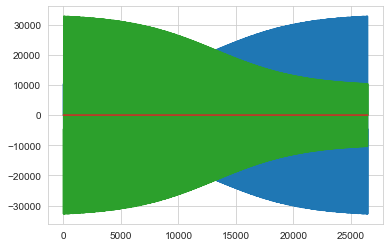

In [175]:
def generate_looming_receding_pair(f_zero = 1000,
                                   duration = 600,
                                   decibel = 10, 
                                   is_sigmoid = True,
                                   flat = 100,
                                   slope = 7,
                                   int16 = True):

    # sine
    sample_rate = 44100
    t,y = generate_pure_tone(amplitude = 1.0,
                             f_zero = f_zero,
                             duration = duration,
                             sample_rate = sample_rate)
    
    # ramp
    ramp = generate_ramp (decibel = decibel,
                          n_points = len(y),
                          n_start = int(flat*sample_rate/1000),
                          n_end = int(flat*sample_rate/1000),
                          is_sigmoid = is_sigmoid, 
                          slope = slope)

    
    # looming
    looming = y*ramp
    
    # convert to int 
    if int16: 
        #looming /=1.414
        looming *= 32767
        looming = looming.astype(np.int16)
    
    # invert for receding
    receding = looming[::-1]
    
    # pack params in a str (for .eg. a filename)
    params = '%dHz_%dms_%ddB_sigmoid_%d_flat_%dms_slope_%d.wav'%(f_zero,
                                                                 duration,
                                                                 decibel,
                                                                 is_sigmoid,
                                                                 flat,
                                                                 slope)    
   
    return looming,receding, ramp, params

looming,receding, ramp, params = generate_looming_receding_pair(f_zero = 1000,
                               duration = 600,
                               decibel = 10, 
                               is_sigmoid = True,
                               flat = 0,
                               slope = 7,
                               int16 = True)

Audio(data=looming, rate=sample_rate)
_=plt.plot(looming)
_=plt.plot(ramp)
_=plt.plot(receding)
_=plt.plot(ramp)
plt.savefig('sounds/looming_%s.jpg'%params)

wavfile.write('sounds/looming_%s.wav'%params,sample_rate,looming)

Audio(data=receding, rate=44100)
wavfile.write('sounds/receding_%s.wav'%params,sample_rate,receding)
#plt.xlim([0.2*sample_rate, 0.3*sample_rate])


   


In [153]:
# explore settings

f_zeros = [800,1000,1500]
durations = [400,500,600,700,800]
decibels = [10,15,20]
is_sigmoids = [True,False]
flats = [0,100,150]
slopes = [5,7,10,15]
      
for f_zero in f_zeros:
    for duration in durations:
        for decibel in decibels: 
            for is_sigmoid in is_sigmoids:
                for flat in flats: 
                    for slope in slopes: 
                        
                        loom,recede,ramp = generate_looming_receding_pair(f_zero = f_zero,
                                                       duration = duration,
                                                       decibel = decibel,
                                                       is_sigmoid = is_sigmoid,
                                                       flat = flat,
                                                       slope = slope)
                        
                        file_name_loom = 'sounds/looming_%dHz_%dms_%ddB_sigmoid_%d_flat_%dms_slope_%d.wav'%(f_zero,
                                                                                                duration,
                                                                                                decibel,
                                                                                                is_sigmoid,
                                                                                                flat,
                                                                                                slope)
                        wavfile.write(file_name_loom,sample_rate,loom)
                        
                        file_name_recede = 'sounds/recede_%dHz_%dms_%ddB_sigmoid_%d_flat_%dms_slope_%d.wav'%(f_zero,
                                                                                                duration,
                                                                                                decibel,
                                                                                                is_sigmoid,
                                                                                                flat,
                                                                                                slope)
                        wavfile.write(file_name_recede,sample_rate,recede)
                        
                        
                        
    